# This file is used for exploring the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import math
import sqlite3
import seaborn as sns

In [2]:
# Read in the data
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
vle = pd.read_csv('data/vle.csv')
students = pd.read_csv('data/studentInfo.csv')
student_registration = pd.read_csv('data/studentRegistration.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
student_vle = pd.read_csv('data/studentVle.csv')

con = sqlite3.connect("data/ou.db")
cur = con.cursor()

In [3]:
test_assessments = student_assessments.copy(deep=True)

def add_time_before_deadline():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['time_before_deadline'] = joined_assessments['date_submitted'] - joined_assessments['date']
    
def drop_banked():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['is_banked'] = joined_assessments['is_banked']
    test_assessments = test_assessments[student_assessments.is_banked == 0]
    
def add_assessment_info():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['weight'] = joined_assessments['weight']
    test_assessments['TMA'] = joined_assessments['assessment_type'] == "TMA"
    test_assessments['Exam'] = joined_assessments['assessment_type'] == "Exam"
    test_assessments['CMA'] = joined_assessments['assessment_type'] == "CMA"

def add_previous_average():
    global test_assessments
    # Use a sqlite database to make some calculations a lot quicker
    cur.execute('''
    SELECT (SELECT AVG(score)
        FROM assessments
                 JOIN student_assessments ON assessments.id_assessment = assessments.id_assessment AND
                                             student_assessments.id_student = sa.id_student
        WHERE date < a.date
          AND code_module = a.code_module
          AND assessments.code_presentation = a.code_presentation)
FROM assessments a
         JOIN student_assessments sa ON a.id_assessment = sa.id_assessment;
         ''')
    test_assessments['prev_avg'] = pd.DataFrame(cur.fetchall(), columns=['avg'])['avg']

def add_student_info():
    global test_assessments
    test_assessments = pd.merge(test_assessments, students, on='id_student')
    
# One hot encoding for assessment type
add_time_before_deadline()
drop_banked()
add_assessment_info()
add_previous_average()
add_student_info()

test_assessments.head()

,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,...,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1752,11391,18,0,78.0,-1.0,10.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,1753,11391,53,0,85.0,-1.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
2,1754,11391,115,0,80.0,-2.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
3,1755,11391,164,0,85.0,-2.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
4,1756,11391,212,0,82.0,-3.0,30.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass


In [4]:
# May require --NotebookApp.iopub_data_rate_limit=1.0e10 jupyter parameter
def find_clicks():
    global test_assessments
    cur.execute('''
SELECT COUNT(DISTINCT (student_vle.date)) AS days_worked_on_assessment,
       SUM(student_vle.sum_click)         AS total_clicks_for_assessment,
       MIN(student_vle.date) - a.date     AS days_started_before_assessment_deadline,
       SUM(CASE
               WHEN student_vle.date - a.date = 0 OR student_vle.date - a.date = -1 THEN 1
               ELSE 0 END)                AS total_clicks_on_day_before_deadline,
       student_vle.id_student,
       student_vle.id_assessment
FROM student_vle
         LEFT JOIN assessments a ON student_vle.id_assessment = a.id_assessment
         LEFT JOIN student_assessments sa
                   ON student_vle.id_assessment = sa.id_assessment AND student_vle.id_student = sa.id_student
WHERE student_vle.date IS NOT NULL
  AND a.date IS NOT NULL
GROUP BY student_vle.id_assessment, student_vle.id_student''')
    info = pd.DataFrame(cur.fetchall(), columns=['days_worked_on_assessment', 'total_clicks_for_assessment', 'days_started_before_assessment_deadline', 'total_clicks_on_day_before_deadline', 'id_student', 'id_assessment'])
    print(len(info))
    test_assessments = pd.merge(test_assessments, info, on=['id_student', 'id_assessment'])
find_clicks()

141062


,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,...,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,days_worked_on_assessment,total_clicks_for_assessment,days_started_before_assessment_deadline,total_clicks_on_day_before_deadline
0,1753,11391,53,0,85.0,-1.0,20.0,True,False,False,...,90-100%,55<=,0,240,N,Pass,18,529,-59.0,2
1,1754,11391,115,0,80.0,-2.0,20.0,True,False,False,...,90-100%,55<=,0,240,N,Pass,8,99,-52.0,0
2,1755,11391,164,0,85.0,-2.0,20.0,True,False,False,...,90-100%,55<=,0,240,N,Pass,5,85,-45.0,0
3,1756,11391,212,0,82.0,-3.0,30.0,True,False,False,...,90-100%,55<=,0,240,N,Pass,3,78,-33.0,0
4,1753,28400,52,0,68.0,-2.0,20.0,True,False,False,...,20-30%,35-55,0,60,N,Pass,26,669,-64.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142509,37437,692171,168,0,65.0,-5.0,0.0,False,False,True,...,20-30%,0-35,0,30,N,Pass,13,149,-45.0,0
142510,37438,692171,123,0,100.0,-106.0,0.0,False,False,True,...,20-30%,0-35,0,30,N,Pass,7,192,-41.0,0
142511,37437,650630,177,0,55.0,4.0,0.0,False,False,True,...,30-40%,35-55,0,30,N,Fail,2,17,-37.0,0
142512,37438,650630,189,0,80.0,-40.0,0.0,False,False,True,...,30-40%,35-55,0,30,N,Fail,15,329,-54.0,25


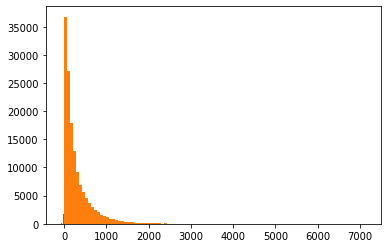

In [5]:
hist(test_assessments.days_worked_on_assessment, bins=100)
hist(test_assessments.total_clicks_for_assessment, bins=100)
hist(test_assessments.days_started_before_assessment_deadline, bins=100)
test_assessments

84092


,time_before_deadline,weight,prev_avg,num_of_prev_attempts,studied_credits,days_worked_on_assessment,total_clicks_for_assessment,days_started_before_assessment_deadline,total_clicks_on_day_before_deadline
0,-1.0,20.0,77.2,0,240,18,529,-59.0,2
1,-2.0,20.0,64.2,0,240,8,99,-52.0,0
2,-2.0,20.0,82.0,0,240,5,85,-45.0,0
3,-3.0,30.0,65.8,0,240,3,78,-33.0,0
4,-2.0,20.0,60.4,0,60,26,669,-64.0,4


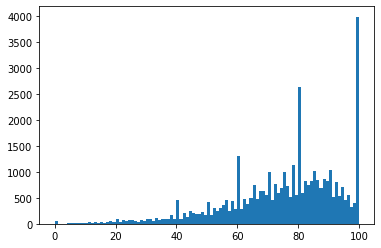

In [6]:
from sklearn.model_selection import train_test_split

test_assessments = test_assessments.dropna()
# 100 and 80 needs to be dealt with, too many of them
#test_assessments = test_assessments[test_assessments.score != 100]
#test_assessments = test_assessments[test_assessments.score != 80]
dropped = test_assessments.drop(["id_assessment", "id_student", "is_banked", "date_submitted", "gender", "region", 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result', 'code_module', 'code_presentation'], axis=1)

# The previous average score affect performace about 0.5 RMSE if left out
#dropped = dropped.drop(["prev_avg"], axis=1)

# The type of assessment did not matter
dropped = dropped.drop(["TMA", "Exam", "CMA"], axis=1)
X = dropped.drop(['score'], axis=1)
y = dropped.score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.333)
print(len(X_train))
hist(y_test, bins=100)
X.head()

[-5.69819287e-02 -1.36998270e-01  1.50934650e-01 -2.81575602e+00
 -1.83079700e-02  4.65202486e-01  1.36848690e-03  1.69476021e-01
 -2.03529214e-02]
Error: 18.008230275800695
Variance: 0.09889032456109659
Error: 24.227180911697403
Variance: -0.4602943151439043
[-5.69819719e-02 -1.36998182e-01  1.50934701e-01 -2.81558410e+00
 -1.83083325e-02  4.65202705e-01  1.36848912e-03  1.69475853e-01
 -2.03529993e-02]
Error: 18.00822995329069
Variance: 0.09889035684199454
[-0.05604289 -0.13265953  0.1461388  -0.         -0.02326894  0.43280028
  0.00175714  0.15125897 -0.004225  ]
Error: 18.047236016174566
Variance: 0.09498271285336146
[0.09562624 0.12674327 0.19544141 0.01614805 0.04736623 0.08888305
 0.22231717 0.11367303 0.09380156]
Error: 9.493309970980297
Variance: 0.7498407216828163
Best model test error: 9.46979519546792
Best model variance: 0.750450848518622
Best model r2: 0.7503250698686986


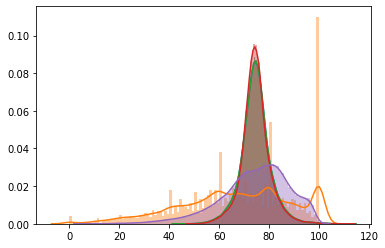

In [7]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor

# Models to be tested
models = [
    LinearRegression(),
    KNeighborsClassifier(),
    Ridge(),
    Lasso(),
    #BayesianRidge(),
    RandomForestRegressor(n_estimators = 500, random_state=1),
    #MLPRegressor(),
]

best_corr = None
best_error = 100
best = None

for model in models:
    model.fit(X_train, y_train)
    try:
        best_corr = model.coef_
        print(model.coef_)
    except Exception as e:
        pass
    try:
        best_corr = model.feature_importances_
        print(model.feature_importances_)
    except Exception as e:
        pass
    y_prediction = model.predict(X_val)
    error = np.sqrt(mean_squared_error(y_val, y_prediction))
    if error < best_error:
        best_error = error
        best = model
    print(f"Error: {error}")
    print(f"Variance: {explained_variance_score(y_val, y_prediction)}")
    sns.distplot(y_prediction, bins=100)

y_prediction = best.predict(X_test)
print(f"Best model test error: {np.sqrt(mean_squared_error(y_test, y_prediction))}")
print(f"Best model variance: {explained_variance_score(y_test, y_prediction)}")
print(f"Best model r2: {r2_score(y_test, y_prediction)}")

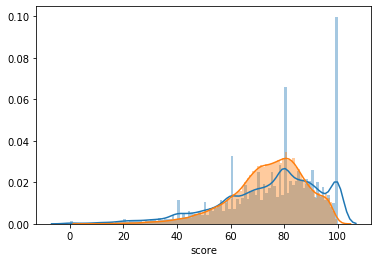

In [8]:
# The true and predicted values
sns.distplot(y_test, bins=100)
sns.distplot(y_prediction, bins=100)

[Text(0, 0.5, 'Distribution'), Text(0.5, 0, 'Error')]

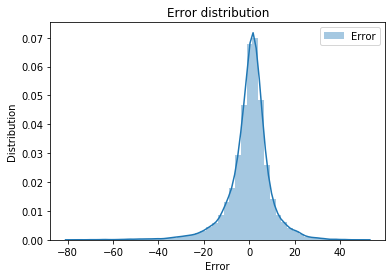

In [22]:
# The distribution of the error visualized
ax = sns.distplot(y_test - y_prediction)
ax.legend(labels=['Error'])
ax.set_title("Error distribution")
ax.set(xlabel='Error', ylabel='Distribution')

In [10]:
from sklearn.metrics import accuracy_score
rounded_test = np.ceil(y_test / 10) * 10
rounded_prediction = np.ceil(y_prediction / 10) * 10

# Accuracy by grade letter
accuracy_score(rounded_test, rounded_prediction)

0.5341465853414659

Text(0.5, 1, 'Feature importance')

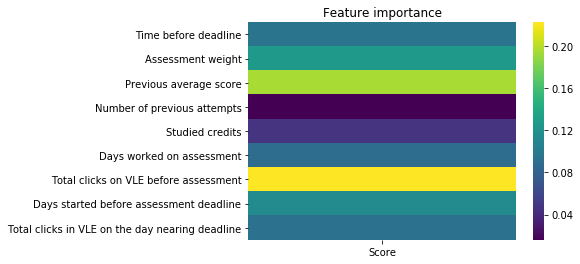

In [16]:
# The correlation of the features visualized
ax = sns.heatmap(
    pd.DataFrame({"Score": best_corr}, index=["Time before deadline", "Assessment weight", "Previous average score", "Number of previous attempts", "Studied credits", "Days worked on assessment", "Total clicks on VLE before assessment", "Days started before assessment deadline", "Total clicks in VLE on the day nearing deadline"]), 
    #vmin=-1, vmax=1, center=0,
    cmap="viridis",
    fmt="g"
)
ax.set_title('Feature importance')